In [1]:
!pip install dask[complete] torch_geometric

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [3]:
df = dd.read_csv("HI-Medium_Trans.csv")


In [4]:
data = df.compute()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898238 entries, 0 to 679783
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           string 
 1   From Bank           int64  
 2   Account             string 
 3   To Bank             int64  
 4   Account.1           string 
 5   Amount Received     float64
 6   Receiving Currency  string 
 7   Amount Paid         float64
 8   Payment Currency    string 
 9   Payment Format      string 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), string(6)
memory usage: 3.8 GB


In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [7]:
data.rename(columns = {'Account':'From acc'}, inplace = True)
data.rename(columns = {'Account.1':'To acc'}, inplace = True)

In [8]:
data.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022-09-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022-09-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022-09-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022-09-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898238 entries, 0 to 679783
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   From acc            string        
 3   To Bank             int64         
 4   To acc              string        
 5   Amount Received     float64       
 6   Receiving Currency  string        
 7   Amount Paid         float64       
 8   Payment Currency    string        
 9   Payment Format      string        
 10  Is Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), string(5)
memory usage: 3.5 GB


In [10]:
print(data.isnull().sum())


Timestamp             0
From Bank             0
From acc              0
To Bank               0
To acc                0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


In [11]:
print(data.shape)

(31898238, 11)


In [12]:
data = data.drop_duplicates(keep = 'first')
data.shape

(31898218, 11)

In [13]:
data.nunique()

Timestamp               26086
From Bank              122330
From acc              2013627
To Bank                 62820
To acc                1689925
Amount Received       2824359
Receiving Currency         15
Amount Paid           2850751
Payment Currency           15
Payment Format              7
Is Laundering               2
dtype: int64

In [14]:
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month

In [15]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]

In [16]:
print(len(Laundering))
print(len(Non_Laundering))

35230
31862988


In [17]:
Laundering.nunique()

Timestamp             19455
From Bank              4108
From acc              22772
To Bank                4589
To acc                26629
Amount Received       34052
Receiving Currency       15
Amount Paid           34052
Payment Currency         15
Payment Format            5
Is Laundering             1
Year                      1
Month                     1
dtype: int64

In [18]:
inter_currency_transactionsL = Laundering[Laundering['Receiving Currency'] != Laundering['Payment Currency']]
inter_currencyL = inter_currency_transactionsL.groupby(['Receiving Currency', 'Payment Currency']).size().reset_index(name='Transaction Count')
inter_currencyL.describe()

,Transaction Count
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [19]:
same_currency_transactionsL = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
same_currencyL = same_currency_transactionsL.groupby('Payment Currency').size().reset_index(name='Transaction Count')

same_currencyL.describe()

,Transaction Count
count,15.000000
mean,2348.666667
std,4070.513967
min,224.000000
25%,338.000000
50%,737.000000
75%,1543.000000
max,14292.000000


In [20]:
same_currencyL

,Payment Currency,Transaction Count
0,Australian Dollar,737
1,Bitcoin,244
2,Brazil Real,279
3,Canadian Dollar,605
4,Euro,9710
5,Mexican Peso,346
6,Ruble,1457
7,Rupee,830
8,Saudi Riyal,224
9,Shekel,658


In [21]:
same_currL = data[data['Receiving Currency'] == data['Payment Currency']]
cross_currL = data[data['Receiving Currency'] != data['Payment Currency']]
same_count = len(same_currL)
cross_count = len(cross_currL)

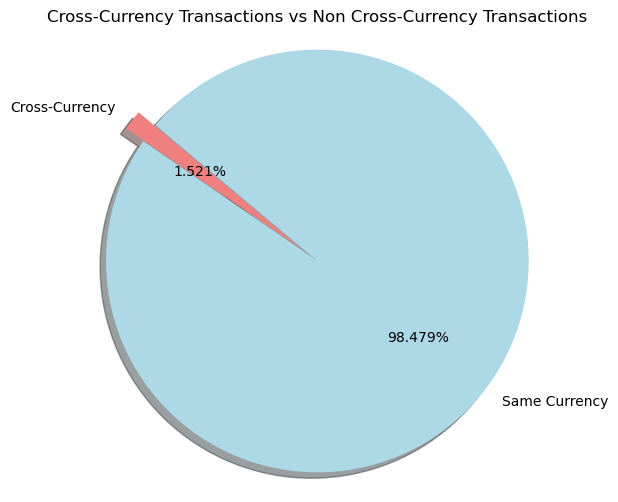

In [22]:
labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_count, same_count]
colors = ['lightcoral', 'lightblue']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


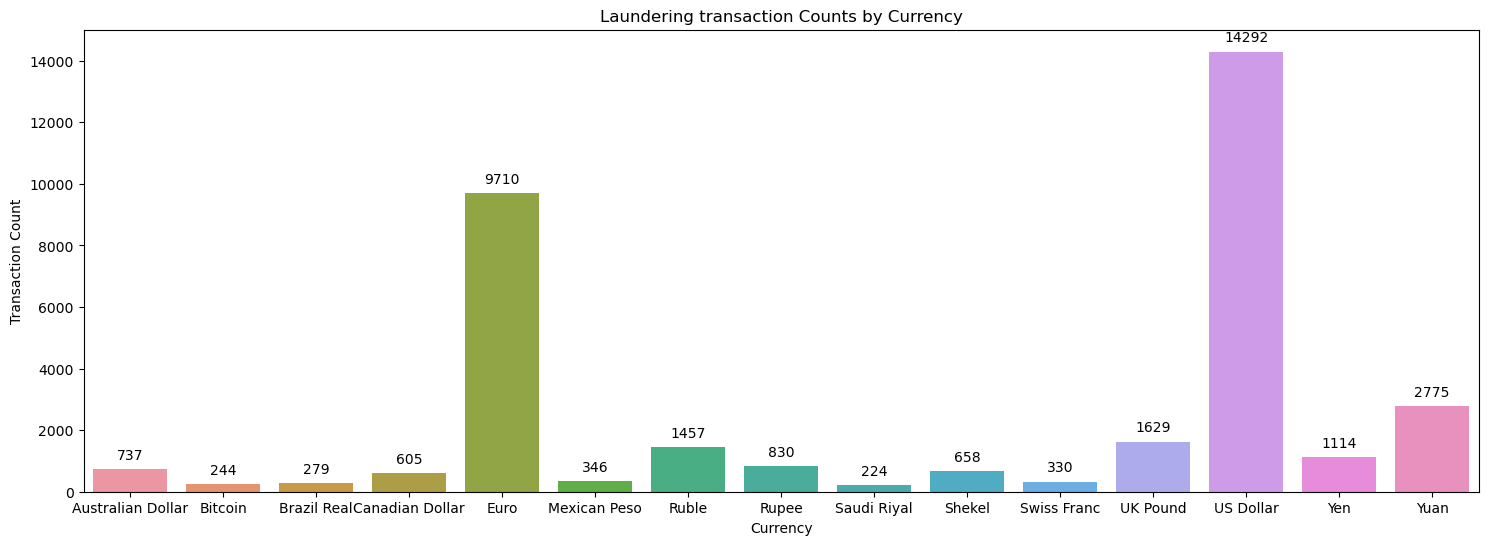

In [23]:
plt.figure(figsize=(18, 6))
ax=sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currencyL)
plt.title('Laundering transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


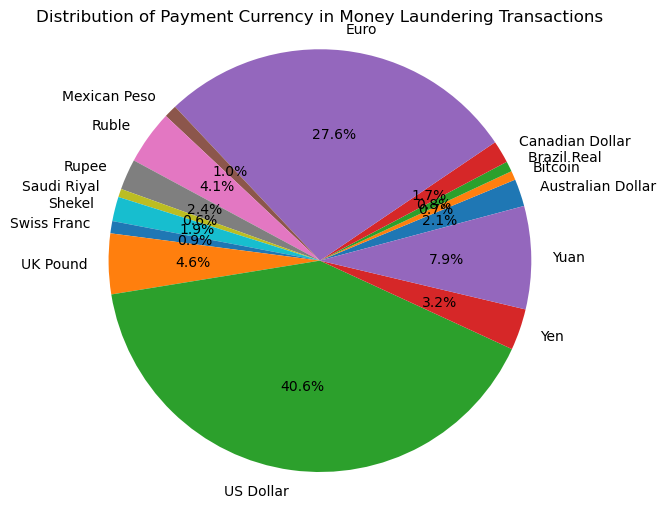

In [24]:
plt.figure(figsize=(6, 6))
plt.pie(same_currencyL['Transaction Count'], labels=same_currencyL['Payment Currency'], autopct='%1.1f%%', startangle=15)
plt.title('Distribution of Payment Currency in Money Laundering Transactions')
plt.axis('equal')
plt.show()

In [25]:
payment_format_data = data.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_format_data.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
3,Cheque,12280058
4,Credit Card,8777816
0,ACH,3868404
2,Cash,3217531
1,Bitcoin,689025


In [26]:
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_formatL.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
0,ACH,30746
3,Cheque,2220
4,Credit Card,1354
2,Cash,666
1,Bitcoin,244


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


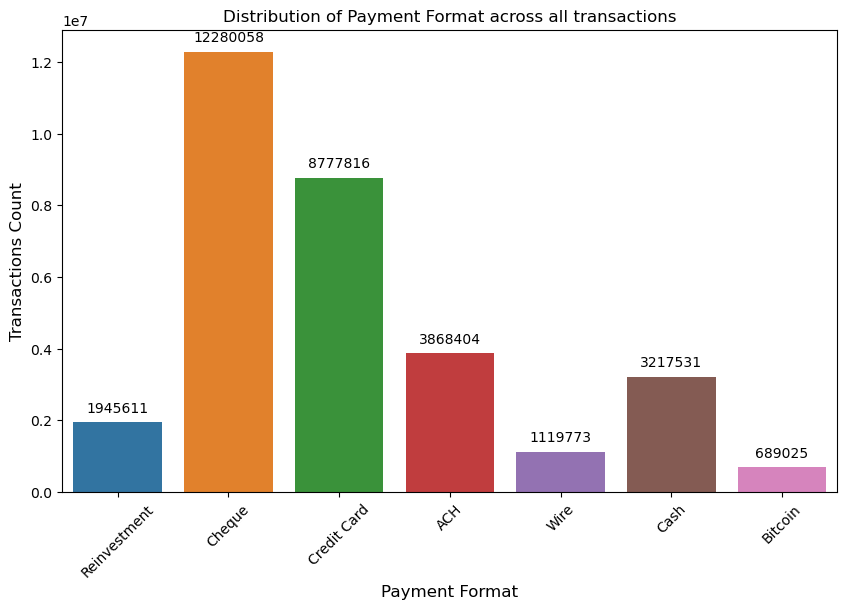

In [27]:
fig, axes = plt.subplots(figsize=(10,6))

sns.countplot(x='Payment Format',data=data, ax=axes)
axes.set_title('Distribution of Payment Format across all transactions')
axes.set_xlabel('Payment Format', fontsize=12)
axes.set_ylabel('Transactions Count', fontsize=12)
axes.tick_params(axis='x', labelrotation=45) 
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')


plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


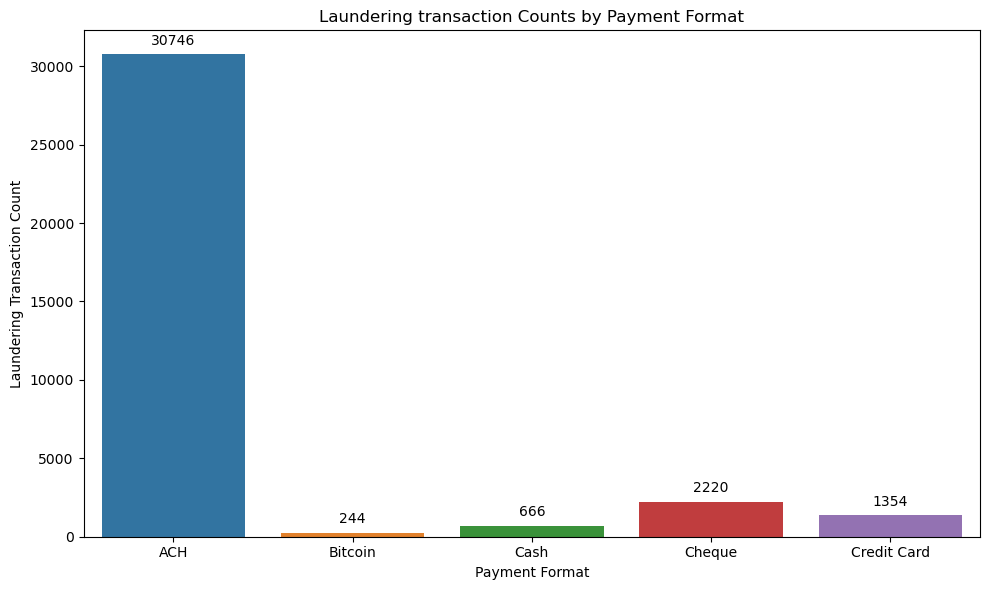

In [28]:

fig, axes = plt.subplots(figsize=(10,6))

sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes)
axes.set_title('Laundering transaction Counts by Payment Format')
axes.set_xlabel('Payment Format')
axes.set_ylabel('Laundering Transaction Count')
plt.tight_layout()

for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.show()

(-1.0999999643463694,
 1.099999998302208,
 -1.0999999031604801,
 1.099999804316355)

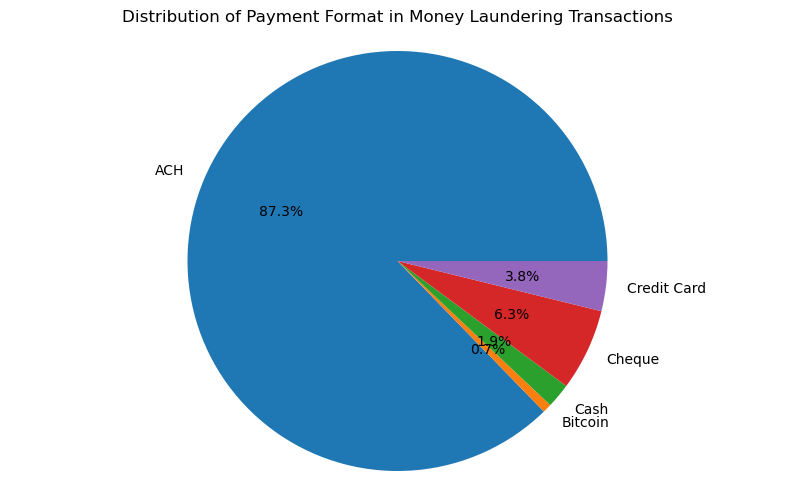

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

ax.pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
ax.set_title('Distribution of Payment Format in Money Laundering Transactions')
ax.axis('equal')

/tmp/ipykernel_815/1191750622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
/tmp/ipykernel_815/1191750622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Day'] = Laundering['Timestamp'].dt.day


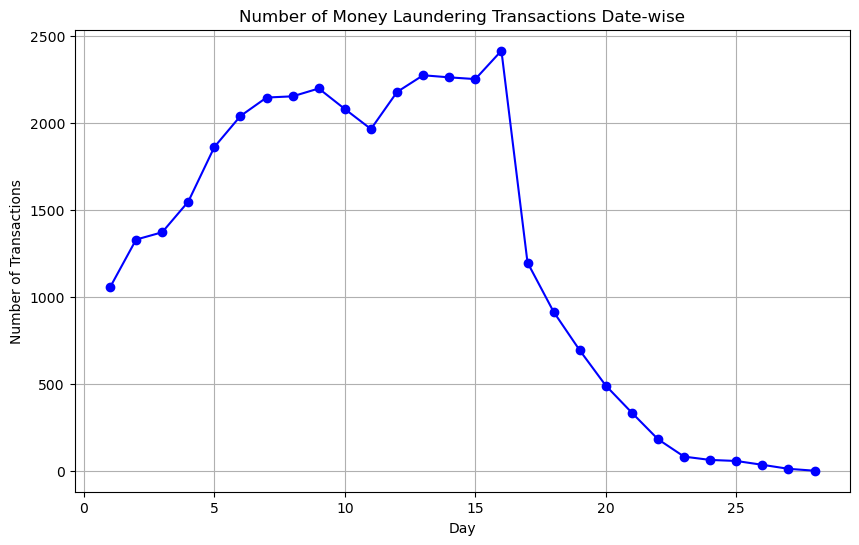

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
Laundering['Day'] = Laundering['Timestamp'].dt.day
daily_transactions = Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

/tmp/ipykernel_815/1252191665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
/tmp/ipykernel_815/1252191665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day


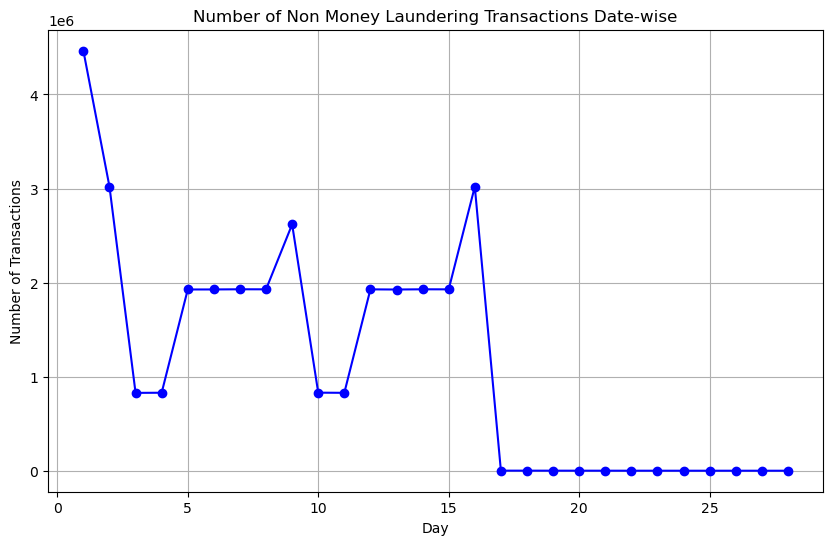

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day
daily_transactions = Non_Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Non Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [32]:
string_cols = data.select_dtypes(include=['string']).columns.tolist()
string_cols


['From acc',
 'To acc',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [33]:
for col in string_cols:
    print(col,'\n')
    print(data[col].nunique(), '\n')
    print(data[col].value_counts())

From acc 

2013627 

From acc
100428660    1076979
1004286A8     678929
1004286F0     208695
1004289C0     132783
100428858     102358
              ...   
838DAA880          1
83D234540          1
8432CBD30          1
8521BB2E1          1
8521E8FF1          1
Name: count, Length: 2013627, dtype: int64[pyarrow]
To acc 

1689925 

To acc
100428660    6842
1004286A8    4304
1004286F0    1539
1004289C0     855
100428858     637
             ... 
800DA10F0       1
82B61A300       1
82792FFE0       1
82F846A80       1
81949BC00       1
Name: count, Length: 1689925, dtype: int64[pyarrow]
Receiving Currency 

15 

Receiving Currency
US Dollar            11594241
Euro                  7329169
Yuan                  2295849
Shekel                1428622
Canadian Dollar       1089398
UK Pound              1020042
Ruble                  989319
Australian Dollar      931364
Yen                    860154
Swiss Franc            856680
Mexican Peso           852272
Rupee                  741594
Bitcoi

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [35]:
# Select columns of type 'string'
string_cols = data.select_dtypes(include=['string']).columns.tolist()
print(string_cols)

# Quantify columns of type 'string' using Label Encoding
label_encoder = LabelEncoder()
for col in string_cols:
    if col != 'Payment Format':
        data[col] = label_encoder.fit_transform(data[col])

# Sort based on the complexity of payment
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use the map method to encode the 'Payment Format' column
data['Payment Format'] = data['Payment Format'].map(payment_map)

# Output the processed data
data.head()


['From acc', 'To acc', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,2022-09-01 00:17:00,20,963,20,926,6794.63,12,6794.63,12,7,0,2022,9
1,2022-09-01 00:02:00,3196,976,3196,939,7739.29,12,7739.29,12,7,0,2022,9
2,2022-09-01 00:17:00,1208,1020,1208,979,1880.23,12,1880.23,12,7,0,2022,9
3,2022-09-01 00:03:00,1208,1023,20,983,73966883.00,12,73966883.00,12,2,0,2022,9
4,2022-09-01 00:02:00,1208,1023,20,985,45868454.00,12,45868454.00,12,2,0,2022,9


In [36]:
# Normalizing all attributes

# Separating labels from the dataset
labels = data['Is Laundering']
data = data.drop('Is Laundering', axis=1)

# Converting the Timestamp column to Unix timestamp

data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype(int) / 10**9

# Normalizing the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)
data_normalized = scaler.transform(data)

# Converting the normalized data back to a DataFrame object and setting column names
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

# Adding the label column back to the normalized dataset
data_normalized['Is Laundering'] = labels.tolist()

# Outputting the normalized data
print(data_normalized.head())


   Timestamp  From Bank  From acc   To Bank    To acc  Amount Received  \
0  -0.999147  -0.999988 -0.999044 -0.999988 -0.998904        -1.000000   
1  -0.999900  -0.998018 -0.999031 -0.998018 -0.998889        -1.000000   
2  -0.999147  -0.999251 -0.998987 -0.999251 -0.998841        -1.000000   
3  -0.999849  -0.999251 -0.998984 -0.999988 -0.998837        -0.999982   
4  -0.999900  -0.999251 -0.998984 -0.999988 -0.998834        -0.999989   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  Year  \
0            0.714286    -1.000000          0.714286        1.000000  -1.0   
1            0.714286    -1.000000          0.714286        1.000000  -1.0   
2            0.714286    -1.000000          0.714286        1.000000  -1.0   
3            0.714286    -0.999982          0.714286       -0.666667  -1.0   
4            0.714286    -0.999989          0.714286       -0.666667  -1.0   

   Month  Is Laundering  
0   -1.0              0  
1   -1.0              0  
2   -1.0

In [37]:
data_normalized=data_normalized.drop(['Month', 'Year'], axis=1)


In [38]:
data_normalized.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,-0.999147,-0.999988,-0.999044,-0.999988,-0.998904,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
1,-0.999900,-0.998018,-0.999031,-0.998018,-0.998889,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
2,-0.999147,-0.999251,-0.998987,-0.999251,-0.998841,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
3,-0.999849,-0.999251,-0.998984,-0.999988,-0.998837,-0.999982,0.714286,-0.999982,0.714286,-0.666667,0
4,-0.999900,-0.999251,-0.998984,-0.999988,-0.998834,-0.999989,0.714286,-0.999989,0.714286,-0.666667,0


In [39]:
data_normalized.columns

Index(['Timestamp', 'From Bank', 'From acc', 'To Bank', 'To acc',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [40]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install -U imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


Training and evaluating Logistic Regression


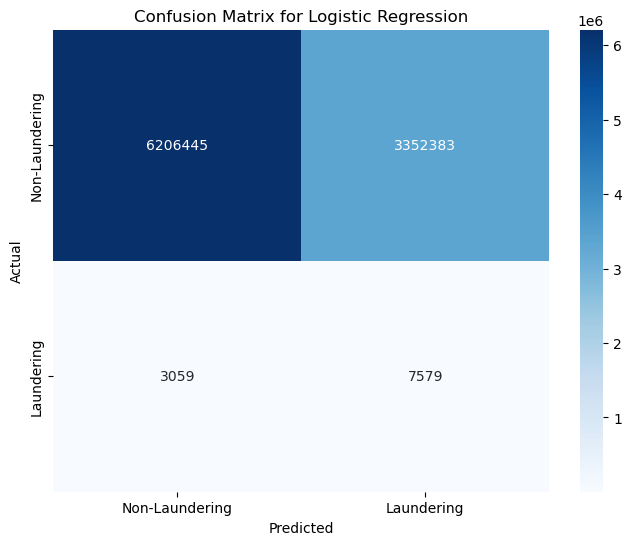


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79   9558828
           1       0.00      0.71      0.00     10638

    accuracy                           0.65   9569466
   macro avg       0.50      0.68      0.40   9569466
weighted avg       1.00      0.65      0.79   9569466



Training and evaluating XGBoost


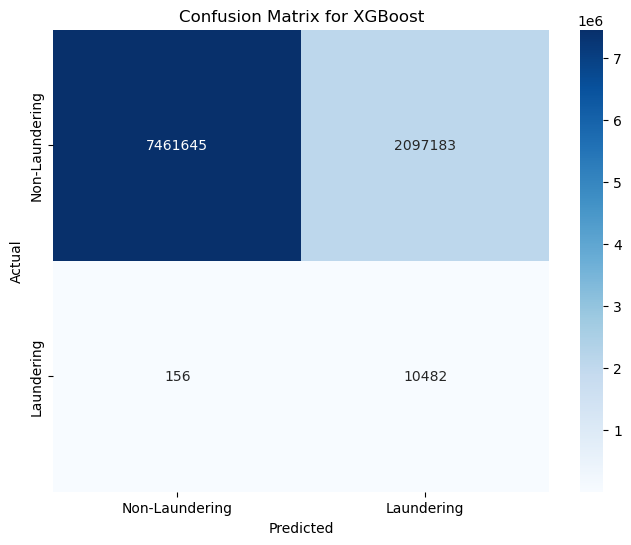


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88   9558828
           1       0.00      0.99      0.01     10638

    accuracy                           0.78   9569466
   macro avg       0.50      0.88      0.44   9569466
weighted avg       1.00      0.78      0.88   9569466



Training and evaluating SVC


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

X = data_normalized.drop('Is Laundering', axis=1)
y = data_normalized['Is Laundering']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle imbalanced data with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Dictionary of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    'SVC': SVC(kernel='linear', random_state=42)  # Consider kernel='linear' for large datasets or 'rbf' for smaller ones
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training and evaluating {name}")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    # Creating a more visually appealing confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Laundering', 'Laundering'], yticklabels=['Non-Laundering', 'Laundering'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*50 + "\n")